#### Scraping and pre-processing a corpus of news article from a set of web-pages and evaluating the performance of automated classification of these articles in a supervised learning context. 

## Part 1

## Data Collection

### Imports

In [1]:
import numpy as np
import pandas as pd
import sklearn
import nltk
import scipy
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Retrieving the monthly news URL's from the website

In [2]:
r  = requests.get("http://mlg.ucd.ie/modules/COMP41680/archive/index.html")

data = r.text

soup = BeautifulSoup(data, "lxml")
monthly_news = []

lists = soup.find_all('li')
    
for link in lists:
    monthly_news.append(link.find("a").get('href'))

print("Scraped %d months news lists" % len(monthly_news) )

Scraped 12 months news lists


### Retrieving news urls and category lables for each month

In [3]:
articles = {} # Creating a dictionary to store articles and category

for month in monthly_news:
    
    r  = requests.get("http://mlg.ucd.ie/modules/COMP41680/archive/" + month)

    data = r.text

    soup = BeautifulSoup(data, "lxml")
    
    
    news_list = soup.find('tbody').find_all('tr')

    
    for news in news_list:
        category_td = news.find("td", {"class": "category"})
        category = category_td.text.strip() #Removing the escape characters from category
                
        if (category != 'N/A'):
            news_links = news.find("td", {"class": "title"})
            news_href = news_links.find("a").get('href')
            
            article_link = "http://mlg.ucd.ie/modules/COMP41680/archive/" + news_href
            
            r  = requests.get(article_link)

            data = r.text

            soup = BeautifulSoup(data, "lxml") 
            
            article_text = ''
            article = soup.find("div", {"class":"main"}).findAll('p')
            for element in article:
                article_text += ' '.join(element.findAll(text = True))
                
            
            article_text = article_text.replace('"', '\\"')
            articles[article_text] = category  

print("Scraped %d news corpus" % len(articles) )
    

Scraped 1394 news corpus


### Storing the articles to a csv file

In [4]:
fout = "articles.csv"
fo = open(fout, "w")

fo.write('Article|Category\n')
for k, v in articles.items():
    fo.write(str(k) + '|'+ str(v) + '\n')

fo.close()

## Part 2

## Text Classification

### Imports

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection

### Reading csv file into a dataframe

In [6]:
raw_data = pd.read_csv("articles.csv", delimiter="|",engine='python')
raw_data.head()

,Article,Category
0,The sporting industry has come a long way sinc...,technology
1,Asian quake hits European sharesShares in Euro...,business
2,BT is offering customers free internet telepho...,technology
3,Barclays shares up on merger talkShares in UK ...,business
4,England centre Olly Barkley has been passed fi...,sport


In [7]:
articles_list = raw_data['Article'].tolist() #Getting news corpus to data
print(len(articles_list))

1394


### Text Pre-processing and Term Weighting

To process the corpuses we will be following these steps:
1. Splitting raw text to tokens (Tokenization)
2. Converting all text to lower case
3. Removing short terms and stop words
4. Stem/Lemmatise tokens
5. Filter out infrequent terms
6. Giving weights to terms
7. Creating a document term matrix

#### Text Preprocessing

By default Scikit-learn converts tokens to lowercase and removes
tokens of length 1 (i.e. single letters).

In [9]:
vectorizer = CountVectorizer(stop_words="english",  min_df = 5) # Preprocessing data to remove stop words and filter out terms appearing in less than 5 documents 
X = vectorizer.fit_transform(articles_list)

print(X.shape)

(1394, 6703)


This process also build a vocabulary for the corpus, both in the form of a list and in the form of a dictionary:

In [10]:
terms = vectorizer.get_feature_names()
vocab = vectorizer.vocabulary_
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 6703 distinct terms


Display some sample terms:

In [11]:
print(terms[500:530])

['appointed', 'appointment', 'appreciate', 'approach', 'approached', 'appropriate', 'approval', 'approvals', 'approve', 'approved', 'april', 'arabia', 'arbitration', 'arcade', 'arch', 'architecture', 'arcy', 'area', 'areas', 'aren', 'arena', 'argentina', 'argentine', 'arguably', 'argue', 'argued', 'argues', 'arguing', 'argument', 'arguments']


To use NLTK lemmatisation with Scikit-learn, we need to create a custom tokenisation function:

In [12]:
# define the function
def lemma_tokenizer(text):
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform lemmatisation on each token
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens:
        lemma_tokens.append( lemmatizer.lemmatize(token) )
    return lemma_tokens

Now we can use our custom tokenizer with the standard CountVectorizer approach:

In [13]:
vectorizer = CountVectorizer(stop_words="english",min_df = 5,tokenizer=lemma_tokenizer)
X = vectorizer.fit_transform(articles_list)
print(X.shape)

(1394, 6010)


In [14]:
print(list(vectorizer.vocabulary_.keys())[0:35])

['sporting', 'industry', 'ha', 'come', 'long', 'way', '60', 'niche', 'root', 'deep', 'sport', 'showing', 'sign', 'decline', 'time', 'soon', 'later', 'reason', 'seemingly', 'difference', 'customer', 'fan', 'leader', 'ownership', 'group', 'king', 'explained', 'face', 'ceo', 'business', 'dying', 'position', 'passion', 'certainly', 'going']


#### Term Weighting

We can improve the usefulness of the document-term matrix by giving higher weights to more "important" terms.
The most common normalisation is term frequency–inverse document frequency (TF-IDF). In Scikit-learn, we can generate at TF-IDF weighted document-term matrix by using TfidfVectorizer() in place of CountVectorizer().

In [15]:
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words="english",min_df = 5,tokenizer=lemma_tokenizer)
X = vectorizer.fit_transform(articles_list)
# display some sample weighted values
print(X.shape)

(1394, 6010)


#### Document Term Matrix

We can use the same Scikit-learn functionality to create a document-term matrix with N-grams.

In [16]:
# we can pass in the same preprocessing parameters and also We specify an extra parameter ngram_range which specifies the shortest and longest token sequences to include.
vectorizer = TfidfVectorizer(stop_words="english",min_df = 5,tokenizer=lemma_tokenizer,ngram_range = (1,2))
document_matrix = vectorizer.fit_transform(articles_list)
# display some sample weighted values
print(document_matrix.shape)

(1394, 9600)


As we can see this approach significantly increases the size of the vocabulary for a given corpus.

### Text Classification

Before we create classifiers we need to divide the dataset into training and test documents

In [17]:
X = raw_data['Article'].tolist() #Articles
Y = raw_data['Category'].tolist() # Labels

In [18]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, \
                                        y_train_plus_valid, \
                                        random_state=0, \
                                        train_size = 0.5/0.7)

/Users/burhanuddinshakir/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Using the previous vectorizer to create a document-matrix of training data

In [19]:
train_X = vectorizer.fit_transform(X_train)
print(train_X.shape)

(696, 5060)


Building a KNN model for it

In [49]:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(train_X, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Creating a document-term matrix from test documents. We call transform() to use the same vocabulary as before.

In [50]:
test_X = vectorizer.transform(X_test)
print(test_X.shape)

(419, 5060)


Making predictions for our test documents using the KNN model and the test document-term matrix

In [56]:
predicted = model_knn.predict(test_X)
predicted[:5]

array(['technology', 'sport', 'sport', 'sport', 'sport'],
      dtype='<U10')

In [57]:
# Print performance details
accuracy_knn = metrics.accuracy_score(y_test, predicted) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy_knn))
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.957040572792
             precision    recall  f1-score   support

   business       0.93      0.96      0.95       132
      sport       0.99      0.95      0.97       171
 technology       0.93      0.97      0.95       116

avg / total       0.96      0.96      0.96       419



Building a Naive Bayes model for it

In [58]:
model_NB = MultinomialNB()
model_NB.fit(train_X, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Making predictions for our test documents using the Naive Bayes model and the test document-term matrix

In [59]:
predicted = model_NB.predict(test_X)
predicted[:5]

array(['technology', 'sport', 'sport', 'sport', 'sport'],
      dtype='<U10')

In [60]:
# Print performance details
accuracy_nb = metrics.accuracy_score(y_test, predicted) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy_nb))
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.973747016706
             precision    recall  f1-score   support

   business       0.95      0.98      0.97       132
      sport       0.99      0.98      0.99       171
 technology       0.98      0.95      0.96       116

avg / total       0.97      0.97      0.97       419



The accuracy we get is ~97.38%, which is not bad for a naive classifier.

### Evaluation

We will evaluate each classifier using the K-Fold cross validation procedure

In [70]:
# prepare configuration for cross validation test harness
seed = 7
#Prepare models
models = []
models.append(('KNN' , model_knn))
models.append(('NB' , model_NB))
results = []
names = []
scoring = 'accuracy'

articles_X = vectorizer.transform(X)

Running cross validation procedure using 10 -fold cross validation

In [71]:
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, articles_X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.959815 (0.009782)
NB: 0.981321 (0.014824)


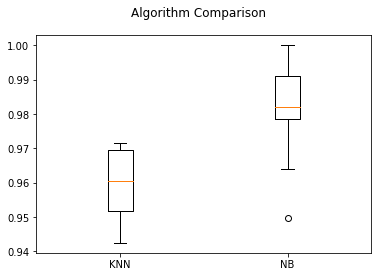

In [72]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From these results, it would suggest that NB analysis provides better accuracy than KNN.

### Conclusion

Most textual data arrives in an unstructured form without any predefined organisation or format, beyond natural language. The vocabulary, formatting, and quality of the text can vary significantly. Tokenising texts, removing stop words and infrequent words, Lemmatising and giving weightage to terms help us understand better what the text is trying to convey this in turn help us in NLP.

The next big challenge arrives to transform tokens to numeric values so that Machine Learning models could train and classify unknown values. This is done using the Bag-of-words model, each document is represented by a vector in
a m-dimensional coordinate space, where m is total number of unique terms across all documents (the corpus vocabulary).

We used NaiveBayes and K-Neireast Neighbours to classify our news corpus. Both have the algotihms gave us a good performance but Naive Bayes had a slightly better result. This can be because it assumes all terms are independent and classify them based on frequency counts. 